In [ ]:
!pip install pysindy

In [35]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pysindy as ps
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

# Introdução

A principal ideia do  SINDy (Sparse Identification of Nonlinear Dynamics) é utilizar uma regressão esparsa para encontrar uma combinação linear de funções que melhor captura  o comportamento da dinâmica de um sistema físico.

Para esse fim, precisamos coletar dados nos tempos $t_1, t_2, \dots, t_n$ das medições do sistema e suas derivadas, representadas pelas seguintes matrizes.

$\begin{split}X = \begin{bmatrix}
    x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
    x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
    \vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
\end{bmatrix},
\qquad
\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
    \dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
    \vdots & \vdots & & \vdots \\
    \dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
\end{bmatrix}.\end{split}$

Após a coleta de dados, escolhemos uma matriz de funções $\Theta(X)$, chamada de biblioteca.

$\begin{split}\Theta(X) = \begin{bmatrix}
    \mid & \mid & & \mid \\
    \theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
    \mid & \mid & & \mid
\end{bmatrix}.\end{split}$

Por fim, queremos encontrar uma matriz esparsa de coeficientes $\Xi$ onde cada coluna nos dá os coeficientes da combinação linear  do conjunto de funções na biblioteca.
 $\begin{split}\Xi = \begin{bmatrix}
    \mid & \mid & & \mid \\
    \xi_1 & \xi_2 & \dots & \xi_n \\
    \mid & \mid & & \mid
\end{bmatrix}.\end{split}$

Sendo assim, temos o seguinte problema de aproximação
$$\dot X \approx \Theta(X)\Xi.$$

# Problema 1

Temos o seguinte problema

\begin{align*}
\dot{x}_1 &= -2x_1 + a_1x_2x_3 + a_2x_4x_5 \\
\dot{x}_2 &= -9x_2 + bx_1x_3 \\
\dot{x}_3 &= -5c_3 - cx_1x_2 + Re \\
\dot{x}_4 &= -5x_4 - dx_1x_5 \\
\dot{x}_5 &= -x_5 + ex_1x_2 \\
\end{align*},

onde $a_1 = 15 , a_2 = 1, b = 2.3 , c = 5 , Re = 4 , d = 0 ,  e = 3$. Para o treinamento do modelo serão utilizadas as condições iniciais $x_1(0) = 2, x_2(0) = 1, x_3(0) = 3, x_4(0) = 1, x_5(0) = 4$. Após o treino, o modelo irá simular a evolução do sistema a partir de diferentes condições.

In [3]:
def navier_stokes(t, z, a1, a2, b, c, Re, d, e):
    x1, x2, x3, x4, x5 = z
    return np.array([
        -2*x1 + a1*x2*x3 + a2*x4*x5,
        -9*x2 + b*x1*x3,
        -5*x3 - c*x1*x2 + Re,
        -5*x4 - d*x1*x5,
        -x5 - e*x1*x5
    ])

In [48]:
t = np.linspace(0, 3, 5000)
sol = solve_ivp(navier_stokes, [0, 3], [2, 1, 3, 1, 4], t_eval = t, args = (15, 1, 2.3, 5, 4, 0, 3))

In [49]:
x_train = sol.y.T
x_dot_train = ps.FiniteDifference()._differentiate(x_train, t)

In [43]:
dados = [(x, x_dot) for x, x_dot in zip(x_train, x_dot_train)]

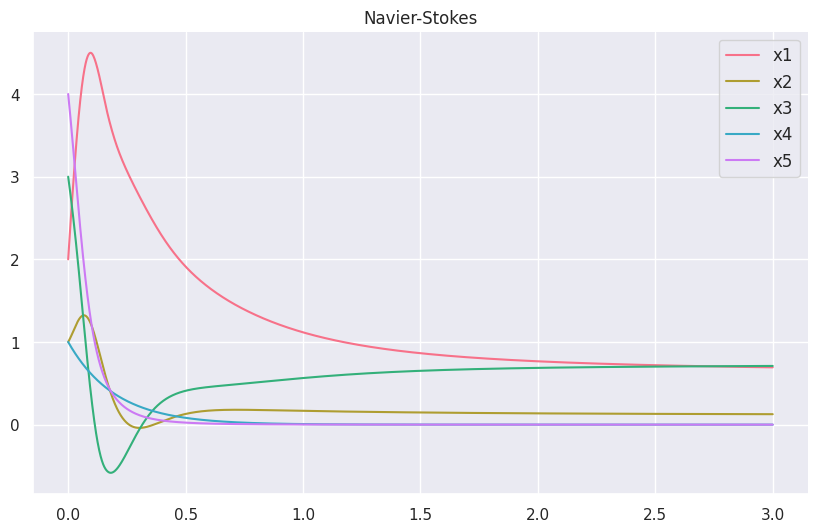

In [50]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('husl', n_colors=5)

for i in range(5):
    sns.lineplot(x=t, y=x_train[:, i], ax=ax, label=f'x{i + 1}', color=colors[i])

ax.set(title='Navier-Stokes')

ax.legend(loc='upper right', fontsize='medium')

sns.despine()

plt.show()

In [51]:
feature_names = ["x1", "x2", "x3", "x4", "x5"]
differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree = 2)
sparse_regression_optimizer = ps.STLSQ(threshold = 0)
model = ps.SINDy(differentiation_method = differentiation_method, feature_names = feature_names, feature_library = feature_library, optimizer = sparse_regression_optimizer)
model.fit(x_train, t=0.0004)
model.print()

(x1)' = -213.804 1 + -21.967 x1 + -369.370 x2 + 431.668 x3 + 872.040 x4 + -1089.077 x5 + 75.319 x1^2 + 28.903 x1 x2 + 27.907 x1 x3 + -1183.929 x1 x4 + 498.840 x1 x5 + -151.627 x2^2 + 99.278 x2 x3 + -116.493 x2 x4 + -1704.031 x2 x5 + -178.087 x3^2 + -1595.993 x3 x4 + 519.758 x3 x5 + 1026.719 x4^2 + 5636.496 x4 x5 + -993.636 x5^2
(x2)' = -42.685 1 + -11.411 x1 + -73.998 x2 + 87.169 x3 + 61.444 x4 + -4.302 x5 + 20.142 x1^2 + -2.695 x1 x2 + 10.032 x1 x3 + -245.347 x1 x4 + 91.418 x1 x5 + -47.061 x2^2 + 27.204 x2 x3 + 50.221 x2 x4 + -418.650 x2 x5 + -35.747 x3^2 + -276.115 x3 x4 + 100.365 x3 x5 + 7.995 x4^2 + 1166.782 x4 x5 + -229.666 x5^2
(x3)' = 29.890 1 + -47.432 x1 + 136.812 x2 + -47.666 x3 + -1002.501 x4 + 1849.599 x5 + 23.347 x1^2 + -64.879 x1 x2 + 2.904 x1 x3 + 127.396 x1 x4 + -102.780 x1 x5 + -102.762 x2^2 + 71.230 x2 x3 + 476.754 x2 x4 + -683.465 x2 x5 + 15.561 x3^2 + 660.441 x3 x4 + -77.950 x3 x5 + -2294.733 x4^2 + 544.754 x4 x5 + -293.367 x5^2
(x4)' = -0.032 1 + -0.018 x1 + 0.009 

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class AutoencoderSINDy(nn.Module):
    def __init__(self, input_size,  latent_size) -> None:
        super().__init__()
        self.sindy_weights = nn.Linear(25, 5).to(torch.float64)
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 10).to(torch.float64),
            nn.ReLU(),
            nn.Linear(10,  5).to(torch.float64),
            nn.ReLU(),
            nn.Linear(5, 5).to(torch.float64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 5).to(torch.float64),
            nn.ReLU(),
            nn.Linear(5, input_size).to(torch.float64),
            nn.ReLU()
        )
    def forward(self, x) -> tuple:
        x.requires_grad_(True)
        z = self.encoder(x)
        z.requires_grad_(True)
        sindy_library = torch.cat([torch.sin(z), torch.cos(z), torch.pow(z, 1), torch.pow(z, 2), torch.pow(z, 3)], dim = 1)
        dz_sindy = self.sindy_weights(sindy_library)
        x_decoder = self.decoder(z)
        dz_dx = torch.autograd.grad(outputs=z, inputs=x, grad_outputs=torch.ones_like(z), create_graph=True)[0]
        dx_decoder_dx = torch.autograd.grad(outputs=x_decoder, inputs=z, grad_outputs=torch.ones_like(x_decoder), create_graph=True)[0]

        return z, dz_sindy, x_decoder, dz_dx, dx_decoder_dx, self.sindy_weights.weight


class Dados(Dataset):
    def __init__(self, data) -> None:
        self.data: list[tuple[list, list]] = data
    def __len__(self) -> int:
        return len(self.data);

    def __getitem__(self, idx: int) -> tuple[list, list]:
        return self.data[idx];

In [ ]:
train_dataset = Dados(dados)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

In [ ]:
def sindy_va_loss(data_set, z, dz_sindy, output, dz_dx, dx_decoder_dx, sindy_weights, l1, l2, l3) -> float:
    x, x_dot = data_set
    loss = nn.MSELoss()
    return loss(output,  x) + l2*torch.norm(sindy_weights, p = 1) + l3*loss(x_dot, dx_decoder_dx*dz_sindy) + l1*loss(x_dot*dz_dx, dz_sindy)

In [ ]:
def train(data, model, optimizer, sindy_va_loss):
    x, x_dot = data
    model.train()
    optimizer.zero_grad()
    z, dz_sindy, output, dz_dx, dx_decoder_dx, sindy_weights = model(x)
    loss = sindy_va_loss(data, z, dz_sindy, output,  dz_dx, dx_decoder_dx, sindy_weights, 0.5, 0.2, 0.3)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def validate_batch(data, model, sindy_va_loss):
    model.eval()
    z, dz_sindy, output, grad_encoder, grad_decoder = model(x)
    loss = sindy_va_loss(data, z, dz_sindy, output, 0.5, 0.2, 0.3)
    return loss


In [ ]:
model = AutoencoderSINDy(5, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 150
for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, data in enumerate(train_loader):
        loss = train(data, model, optimizer, sindy_va_loss)
        pos = epoch + (1+batch_idx)/N
    print(f"epoch: {epoch} | loss: {loss}")

epoch: 0 | loss: 0.42334489529403657
epoch: 1 | loss: 0.5764073508233248
epoch: 2 | loss: 1.2535374768779495
epoch: 3 | loss: 2.6233611250234703
epoch: 4 | loss: 0.28881411656849326
epoch: 5 | loss: 1.3608457785828771
epoch: 6 | loss: 0.2888241738172985
epoch: 7 | loss: 0.04272168378461983
epoch: 8 | loss: 0.26506954284401324
epoch: 9 | loss: 0.486571699562011
epoch: 10 | loss: 1.9710196912483586
epoch: 11 | loss: 0.18663549608558802
epoch: 12 | loss: 1.3258829003071002
epoch: 13 | loss: 0.7415884059762052
epoch: 14 | loss: 0.6772679533683428
epoch: 15 | loss: 0.0573563657347473
epoch: 16 | loss: 1.401236260522489
epoch: 17 | loss: 3.2585623640179087
epoch: 18 | loss: 0.23067133617429023
epoch: 19 | loss: 0.4767141900783706
epoch: 20 | loss: 0.029610550050306196
epoch: 21 | loss: 0.3696979329589807
epoch: 22 | loss: 0.4936251768147877
epoch: 23 | loss: 0.11052318390609717
epoch: 24 | loss: 0.3384873609666932
epoch: 25 | loss: 1.6767435513346995
epoch: 26 | loss: 0.23940322378234596
epo